In [27]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.metrics import *
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
import CONSTANTS
from audioread.ffdec import ReadTimeoutError
from functions import *
warnings.filterwarnings('ignore')

In [28]:
KEY = "98464488-2db9-4ddc-9b98-6b48f8b623dc" # do not change
LIMIT = 365
COIN = 'BTC'

In [29]:
df, coin = prices(COIN, period=365)

In [30]:
df

,time,low,high,open,close,volume,change,pct_change
0,2025-03-02,85003.35,95128.88,86018.82,94265.48,16751.229730,8246.66,9.587042
1,2025-03-01,83772.54,86534.96,84297.74,86018.76,6852.544126,1721.02,2.041597
2,2025-02-28,78167.81,85116.19,84627.50,84297.73,30755.742451,-329.77,-0.389672
3,2025-02-27,82554.11,86993.87,84111.77,84625.19,16836.555247,513.42,0.610402
4,2025-02-26,82111.12,89305.68,88583.17,84111.78,21568.554631,-4471.39,-5.047674
...,...,...,...,...,...,...,...,...
360,2025-03-07,84608.27,91280.00,89915.02,86756.98,27137.202230,-3158.04,-3.512250
361,2025-03-06,87790.50,92817.29,90607.73,89921.85,13302.875001,-685.88,-0.756977
362,2025-03-05,86329.22,91000.00,87247.93,90603.73,14900.933966,3355.80,3.846280
363,2025-03-04,81444.00,88977.27,86161.09,87249.96,23130.370987,1088.87,1.263761


## Find the FGI change and close price change correlation

Do this for all the coins

In [31]:
def get_fgi_data():
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
      fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')
      return fgi_df
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

In [32]:
def fgi_close_association(coin='BTC'):
  try:
    coinPrices, i = prices(coin, period=LIMIT)
  except:
    print('Invalid coin: ', coin)
    print('Period: ', LIMIT)
    return None
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

  # convert timestamp to date
  fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')

  # inner join the prices on the timestamp
  everything = pd.merge(coinPrices, fgi_df, left_on='time', right_on='timestamp', how='inner')
  everything = pd.get_dummies(everything)

  # create pct_change for the fgi value
  everything['fgi_pct_change'] = everything['value'].pct_change()
  everything['fgi_pct_change'].fillna(0, inplace=True)
  everything['pct_change'].fillna(0, inplace=True)
  correlation = everything.corr()
  item1 = correlation['pct_change']['fgi_pct_change']
  item2 = np.sqrt(mean_squared_error(everything['pct_change'], everything['fgi_pct_change']))
  return {
      'coin': coin,
      'correlation': item1,
      'RMSE': item2
  }

In [33]:
coins = ['BTC', 'NEAR', 'ETH', 'AVAX', 'SOL', 'ICP', 'FET']
correlations = [fgi_close_association(coin) for coin in coins]
everything = pd.DataFrame(correlations).sort_values(by='RMSE', ascending=True)

In [34]:
import altair as alt

# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('RMSE')

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='RMSE'
).properties(
    title='RMSE by Coin'  # Add a title to the chart
)

alt.Chart(...)

In [35]:
# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('correlation')
everything_sorted['abs_correlation'] = np.abs(everything_sorted['correlation'])

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='abs_correlation'
).properties(
    title='Correlation Magnitude by Coin'  # Add a title to the chart
)

alt.Chart(...)

## Crypto market collector

In [36]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Constants

# -------------------------------
# 1. Market-Faceted Metrics
# -------------------------------

def get_global_market_data():
    """
    Fetch overall market data such as total market capitalization, trading volume, and Bitcoin dominance.
    Purpose: Helps understand the overall health and activity of the cryptocurrency market.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/latest"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return {
            'total_market_cap': data['data']['quote']['USD']['total_market_cap'],
            'total_volume_24h': data['data']['quote']['USD']['total_volume_24h'],
            'btc_dominance': data['data']['btc_dominance'],
            'active_cryptocurrencies': data['data']['active_cryptocurrencies']
        }
    else:
        print(f"Failed to fetch global market data: {response.status_code}")
        return None

def get_tokenomics(coin):
    """
    Fetch tokenomics data such as circulating supply and total supply.
    Purpose: Helps understand the supply dynamics of a coin, which can influence its price.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/cryptocurrency/info"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    params = {
        'symbol': coin
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        supply_data = data['data'][coin]
        return supply_data
    else:
        print(f"Failed to fetch tokenomics for {coin}: {response.status_code}")
        return None

# -------------------------------
# Additional Metrics
# -------------------------------

market_data = get_global_market_data()

# Fetch tokenomics data
tokenomics_data = get_tokenomics('BTC')

In [37]:
pd.json_normalize(tokenomics_data)

,id,name,symbol,category,description,slug,logo,subreddit,notice,tags,...,urls.website,urls.twitter,urls.message_board,urls.chat,urls.facebook,urls.explorer,urls.reddit,urls.technical_doc,urls.source_code,urls.announcement
0,1,Bitcoin,BTC,coin,Bitcoin (BTC) is a cryptocurrency launched in ...,bitcoin,https://s2.coinmarketcap.com/static/img/coins/...,bitcoin,,"[mineable, pow, sha-256, store-of-value, state...",...,[https://bitcoin.org/],[],[https://bitcointalk.org],[],[],"[https://blockchain.info/, https://live.blockc...",[https://reddit.com/r/bitcoin],[https://bitcoin.org/bitcoin.pdf],[https://github.com/bitcoin/bitcoin],[]


# Steps to train LSTM to predict buy and sell



1.   Obtain additional metrics

* Moving averages (short-term and long-term)
* Relative Strength Index (RSI)
* Moving Average Convergence Divergence (MACD)
* Bollinger Bands
* Volume indicators

2.   Model Approaches

* Classification
  * label buys, sells, holds (1, -1, 0) based on market data
  * predict each label

* Regression
  * predict return over time
    * look at windows of time to find optimal profits
  * identify buy and sell periods



### Generate Metrics

In [38]:
import pandas as pd
import numpy as np

# Assume you have already fetched data using your prices() function,
# and that your DataFrame (df) has at least the following columns:
# ['time', 'low', 'high', 'open', 'close', 'volume']

# ----------------------------
# 1. Moving Averages (SMA & EMA)
# ----------------------------
# Short-term SMA (20 periods) and long-term SMA (50 periods)
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Averages (optional, can be used in place of or along with SMAs)
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

# ----------------------------
# 2. Relative Strength Index (RSI)
# ----------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    # Separate positive and negative gains
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Simple moving average over 'window' periods for gains/losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Alternatively, one can use exponential weighting:
    # avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    # avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['close'], window=14)

# ----------------------------
# 3. Moving Average Convergence Divergence (MACD)
# ----------------------------
# Calculate the 12-period and 26-period EMA of the closing price
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

# MACD line: difference between the 12-EMA and 26-EMA
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Signal line: 9-period EMA of the MACD line
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram: the difference between MACD and its signal line
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# ----------------------------
# 4. Bollinger Bands
# ----------------------------
# Bollinger Bands are typically computed using a moving average and standard deviation.
# Here we use the 20-period SMA (which we already computed) and a factor of 2 standard deviations.
df['BB_Middle'] = df['SMA_20']  # Middle band is the 20-period SMA
df['BB_STD'] = df['close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_STD']
df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_STD']

# Optionally, you can drop the intermediate 'BB_STD' column later if not needed:
# df.drop(columns=['BB_STD'], inplace=True)

# ----------------------------
# 5. Volume Indicators
# ----------------------------
# Example 1: 20-period moving average of volume (helps smooth out spikes)
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()

# Example 2: On-Balance Volume (OBV)
# OBV is designed to relate volume flow to price change.
# We'll start OBV at zero and add/subtract volume depending on price movement.
df['daily_return'] = df['close'].pct_change()  # percentage change in closing price
df['direction'] = np.where(df['daily_return'] > 0, 1, -1)  # +1 for up days, -1 for down days
df.loc[df['daily_return'].isna(), 'direction'] = 0  # set initial value to 0
df['OBV'] = (df['volume'] * df['direction']).fillna(0).cumsum()

# Clean up temporary columns
df.drop(columns=['daily_return', 'direction'], inplace=True)

# ----------------------------
# View the final DataFrame with the newly computed technical indicators
# ----------------------------
df.tail()

# If you wish to inspect or plot these indicators (for example, overlaying Bollinger Bands on price),
# you can use matplotlib, seaborn, or a plotting library of your choice.

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,EMA_26,MACD,MACD_Signal,MACD_Hist,BB_Middle,BB_STD,BB_Upper,BB_Lower,Volume_MA_20,OBV
360,2025-03-07,84608.27,91280.00,89915.02,86756.98,27137.202230,-3158.04,-3.512250,84220.2710,84508.7106,...,83735.830816,-89.059623,-240.878855,151.819232,84220.2710,2420.835838,89061.942677,79378.599323,9829.012327,-174320.896955
361,2025-03-06,87790.50,92817.29,90607.73,89921.85,13302.875001,-685.88,-0.756977,84370.0630,84412.9718,...,84194.054459,418.113473,-109.080389,527.193862,84370.0630,2676.276908,89722.616816,79017.509184,10149.870084,-161018.021954
362,2025-03-05,86329.22,91000.00,87247.93,90603.73,14900.933966,3355.80,3.846280,84528.8555,84344.6072,...,84668.845240,865.101472,85.755983,779.345489,84528.8555,2947.708851,90424.273202,78633.437798,10387.217626,-146117.087989
363,2025-03-04,81444.00,88977.27,86161.09,87249.96,23130.370987,1088.87,1.263761,84515.1725,84214.7880,...,84860.038926,937.909830,256.186752,681.723078,84515.1725,2933.677526,90382.527553,78647.817447,10888.360979,-169247.458975
364,2025-03-03,85007.01,94415.61,94265.47,86161.10,22691.670686,-8104.37,-8.597390,84518.5805,84068.2280,...,84956.413820,897.404358,384.430273,512.974085,84518.5805,2935.645787,90389.872074,78647.288926,11849.571041,-191939.129661


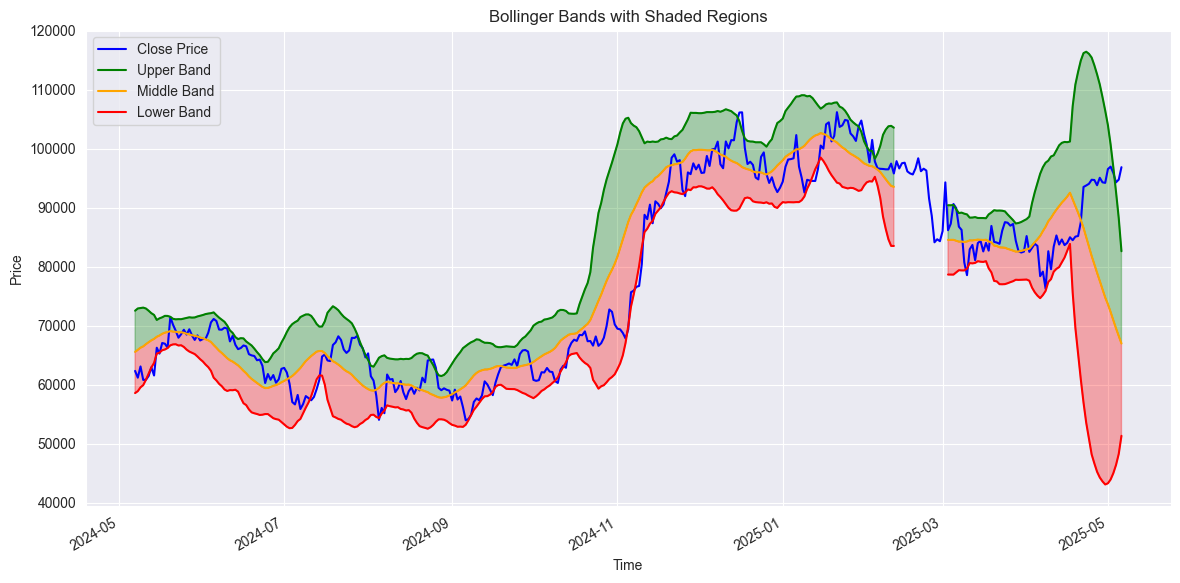

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the DataFrame is sorted by time
df = df.sort_values('time').reset_index(drop=True)

# Optionally drop rows with NaNs in Bollinger Bands, if any (depends on your data)
# df = df.dropna(subset=['BB_Upper', 'BB_Middle', 'BB_Lower'])

fig, ax = plt.subplots(figsize=(14, 7))

# Plot the price and Bollinger Bands
ax.plot(df['time'], df['close'], label='Close Price', color='blue')
ax.plot(df['time'], df['BB_Upper'], label='Upper Band', color='green')
ax.plot(df['time'], df['BB_Middle'], label='Middle Band', color='orange')
ax.plot(df['time'], df['BB_Lower'], label='Lower Band', color='red')

# Shade the area between the upper and middle bands
ax.fill_between(df['time'], df['BB_Upper'], df['BB_Middle'], color='green', alpha=0.3)
# Shade the area between the middle and lower bands
ax.fill_between(df['time'], df['BB_Middle'], df['BB_Lower'], color='red', alpha=0.3)

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Bollinger Bands with Shaded Regions')
ax.legend()
ax.grid(True)

# Optional: improve formatting of x-axis dates
fig.autofmt_xdate()
plt.show()

In [40]:
df.to_csv(fullDataPath(coin), index=False)

## Utilize in model:


* Sentiment Metrics
  * bias
  * sentiment score
* Bollinger Mid Band
* Bias
* Close Price (low weight)
* Volatility

### Steps:



1.   Get articles about a specific coin
2.   Run sentiment analysis on news articles
3.   Calculate volatility
4.   Run LSTM model and/or NN






## Get the news articles for a particular coin